<h1> Chest Diseases (Pnuemonia) Classification Using Machine Learning<h1>

In [40]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc,roc_auc_score, roc_curve,mean_squared_error ,confusion_matrix,ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
import joblib

Data Loading

In [2]:
data_dir = 'chest_xray'
categories = ['normal', 'pneumonia']
data = []
labels = []
img_size = (100, 100)

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = 1 if category == 'pneumonia' else 0
    
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize all images to the same size
                data.append(img)
                labels.append(class_num)
            else:
                print(f"Skipping file {img_name}, unable to read.")
        
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")


In [3]:
# Convert lists to numpy arrays
imgs = np.array(data)
y = np.array(labels)

# Check the shape of imgs and y
print(f"Shape of imgs: {imgs.shape}")
print(f"Shape of y: {y.shape}")


Shape of imgs: (5856, 100, 100, 3)
Shape of y: (5856,)


normal


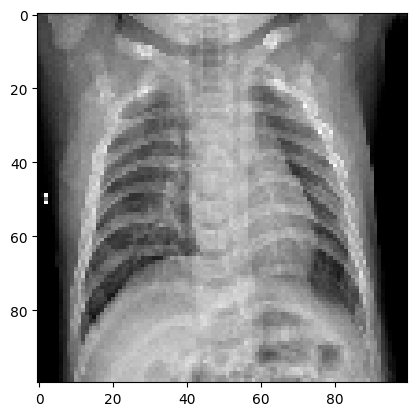

In [4]:
plt.imshow(imgs[2])
if y[2] == 1:
    print('pneumonia')
else:
    print('normal')

pneumonia


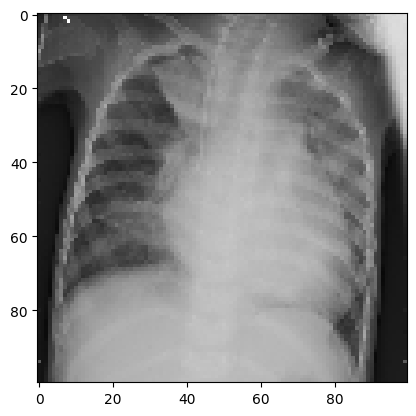

In [5]:
plt.imshow(imgs[4000])
if y[4000] == 1:
    print('pneumonia')
else:
    print('normal')

<h2>Data Preprocessing</h2>

- Color coversion to grayscale
- resize images to 100x100
- Flatten
- standardized

In [6]:
preprocessed_data = []

for img in imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Color Conversion to grayscale
    preprocessed_data.append(img)

x = np.array(preprocessed_data)


normal


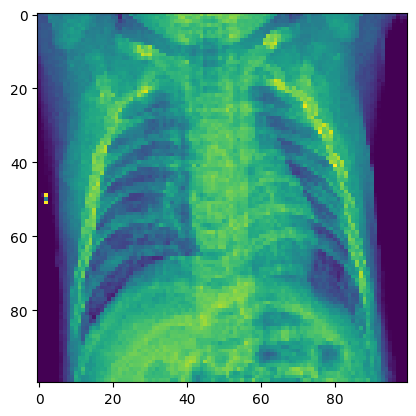

In [7]:
plt.imshow(x[2])
if y[2] == 1:
    print('pneumonia')
else:
    print('normal')

pneumonia


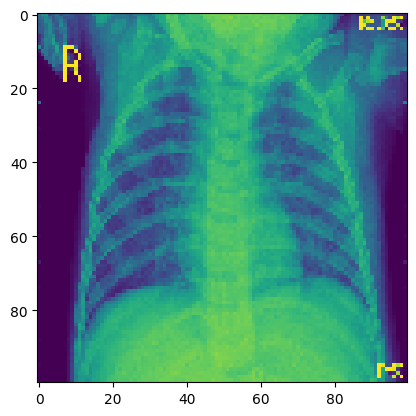

In [8]:
plt.imshow(x[5000])
if y[5000] == 1:
    print('pneumonia')
else:
    print('normal')

- Flatten the images

In [9]:
flattened_imgs = imgs.reshape(imgs.shape[0], -1)
print(f'Images shape after flattening: {flattened_imgs.shape}')

Images shape after flattening: (5856, 30000)


<h2>Feature Selection using Mutual Information<h2>

In [10]:
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

features_selected = selector.fit_transform(flattened_imgs)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)

In [11]:
print(f"Selected features based on variance threshold: {selected_features.shape}")
print(f"Shape of selected features: {features_selected.shape}")

Selected features based on variance threshold: (30000,)
Shape of selected features: (5856, 30000)


- Standardize

In [12]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features_selected)

In [13]:
# Split Data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [19]:
# Combine x_train and y_train to resample together
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train, name='y_train')

# Combine x_train and y_train to resample together
train_data = pd.concat([x_train_df, y_train_df], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.y_train == 1]
minority_class = train_data[train_data.y_train == 0]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                              replace=True,    # sample with replacement
                              n_samples=len(majority_class), # match number in majority class
                              random_state=27) # reproducible results

# Combine majority and upsampled minority
upsampled_train_data = pd.concat([majority_class, minority_upsampled])

# Separate features and labels
x_train = upsampled_train_data.drop('y_train', axis=1)
y_train = upsampled_train_data['y_train']


In [21]:
print("Class distribution in training data:")
(unique, counts) = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique, counts))
print(class_distribution_train)

print("Class distribution in test data:")
(unique, counts) = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique, counts))
print(class_distribution_test)


Class distribution in training data:
{0: 3442, 1: 3442}
Class distribution in test data:
{0: 341, 1: 831}


In [22]:
x_train.shape

(6884, 30000)

<h2>Model Development and Training Using LightGBM</h2>

In [23]:
clf = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    boosting_type='gbdt',
    num_leaves=50,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=7,
)
clf.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 3442, number of negative: 3442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 43.052158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5299302
[LightGBM] [Info] Number of data 

LGBMClassifier(bagging_fraction=0.9, bagging_freq=7, feature_fraction=0.9,
               learning_rate=0.05, metric='binary_logloss', num_leaves=50,
               objective='binary')

<h2>Model Evaluation</h2>

- Accuracy, precison, recall, f1-score, mse

In [25]:
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precison = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Model Evaluation Results:")
print('Accuracy: ', accuracy.__round__(2))
print('Precision: ', precison.__round__(2))
print('Recall: ', recall.__round__(2))
print('F1-Score: ', f1.__round__(2))
print('Mean Squared Error: ', mse.__round__(2))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Model Evaluation Results:
Accuracy:  0.94
Precision:  0.95
Recall:  0.96
F1-Score:  0.96
Mean Squared Error:  0.06


- Confusion Matrix

In [26]:
conf =confusion_matrix(y_test, y_pred)
conf

array([[298,  43],
       [ 30, 801]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Visualization')

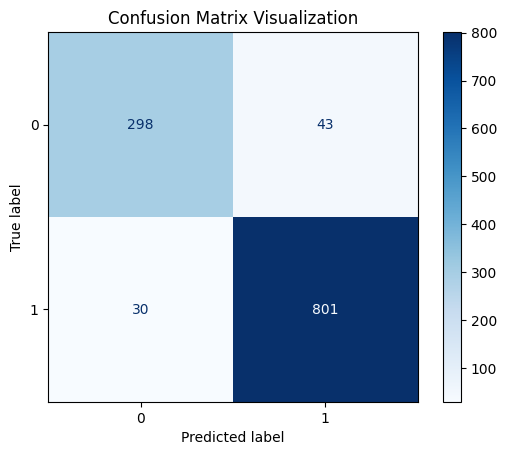

In [27]:
ConfusionMatrixDisplay(conf).plot(cmap="Blues")
plt.title('Confusion Matrix Visualization')

- AUC ROC

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
AUC Score: 0.9810


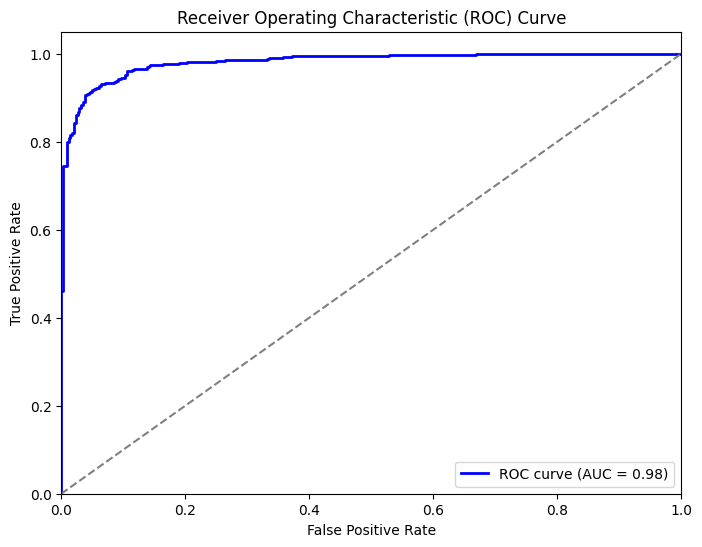

In [ ]:
# Predict probabilities on test data
y_pred_proba = clf.predict_proba(x_test)[:, 1]

#  Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC curve with AUC score
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [41]:
predictions = clf.predict(x_test)
print("Predictions on test data:")
print(predictions)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Predictions on test data:
[1 1 0 ... 0 1 1]


In [38]:
sam = x_test[90]
prediction = clf.predict([sam])[0]
print("outcome:", prediction)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
outcome: 1
